<a href="https://colab.research.google.com/github/Cal723/CSE-337-Labs/blob/main/lab4_dyna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 4: TD and Dyna




## Exercise 1: Implement SARSA with n-step TD (n=5) on CliffWalking

**Objective:**  
In this exercise, you will implement the **SARSA algorithm** using **n-step temporal-difference learning with n=5**. You will apply your implementation to the **CliffWalking environment** in Gymnasium, and analyze how multi-step returns influence learning compared to standard 1-step SARSA.

---

### Environment
- Use `CliffWalking-v1`

---

### Instructions
1. Implement **SARSA with n-step TD updates (n=5)**:
   - Maintain an action-value table \(Q(s,a)\).
   - Use ε-greedy exploration.
   - Store states, actions, and rewards for the last 5 steps.
   - After each step, compute the n-step return: G_t
   - Update \(Q(s_t,a_t)\) toward \(G_t\).

2. Train your agent for several thousand episodes (e.g., 5,000).

3. Plot the **episode rewards over time** to visualize learning progress.

4. Compare qualitatively with 1-step SARSA:
   - Does n-step SARSA converge faster or slower?
   - How do the policies differ near the cliff?

---

### Deliverables
- Python code implementing SARSA with TD(5) (notebook in Github).  
- A plot of episode number vs episode return (plot in a cell below).  
- A short discussion (1 paragraph) comparing the results with standard SARSA.  


Episode 1/50
Episode 2/50
Episode 3/50
Episode 4/50
Episode 5/50
Episode 6/50
Episode 7/50
Episode 8/50
Episode 9/50
Episode 10/50
Episode 11/50
Episode 12/50
Episode 13/50
Episode 14/50
Episode 15/50
Episode 16/50
Episode 17/50
Episode 18/50
Episode 19/50
Episode 20/50
Episode 21/50
Episode 22/50
Episode 23/50
Episode 24/50
Episode 25/50
Episode 26/50
Episode 27/50
Episode 28/50
Episode 29/50
Episode 30/50
Episode 31/50
Episode 32/50
Episode 33/50
Episode 34/50
Episode 35/50
Episode 36/50
Episode 37/50
Episode 38/50
Episode 39/50
Episode 40/50
Episode 41/50
Episode 42/50
Episode 43/50
Episode 44/50
Episode 45/50
Episode 46/50
Episode 47/50
Episode 48/50
Episode 49/50
Episode 50/50


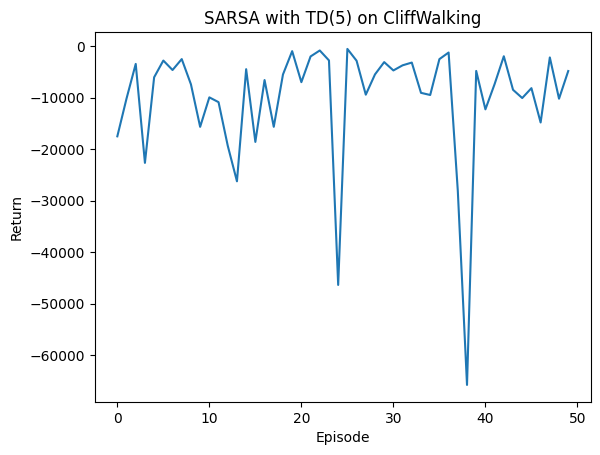

In [65]:
"""
Starter code for Exercise (you can use this code, or extend your code from previous lab)
Implement SARSA with TD(5) on CliffWalking-v1
"""

import numpy as np
import gymnasium as gym
from collections import deque
import matplotlib.pyplot as plt

# Environment
env = gym.make("CliffWalking-v1")

# Parameters
n_states = env.observation_space.n
n_actions = env.action_space.n
alpha = 0.1           # step size (learning rate)
gamma = 0.99          # discount factor
epsilon = 0.5         # epsilon for epsilon-greedy policy
n_step = 5            # number of steps for TD(n)
n_episodes = 50

# Initialize Q-table
Q = np.zeros((n_states, n_actions))

def epsilon_greedy(state):
    """Choose an action using epsilon-greedy policy."""
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

# Track returns
episode_returns = []

for ep in range(n_episodes):
    print(f"Episode {ep+1}/{n_episodes}")
    state, _ = env.reset()
    action = epsilon_greedy(state)

    # Buffers to store the trajectory
    states = []
    actions = []
    rewards = []

    T = float("inf")
    t = 0
    G = 0
    done = False

    while True:
        if t < T:
            # Take real step in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            states.append(state)
            actions.append(action)
            rewards.append(reward)

            if done:
                T = t + 1
            else:
                next_action = epsilon_greedy(next_state)
                state = next_state
                action = next_action

        # Time index for state/action to update
        tau = t - n_step + 1
        if tau >= 0 and tau + n_step < len(states):
            # TODO: Compute the n-step return G for state tau
            # Hint: use rewards[tau : tau+n] plus Q(s_t+n, a_t+n) if not terminal

            # Example structure:
            G = 0.0
            # accumulate discounted rewards
            for i in range(tau, min(tau + n_step, T)):
                G += (gamma ** (i - tau)) * rewards[i]
            if tau + n_step < T:
                s_tau_n = states[tau + n_step]
                a_tau_n = actions[tau + n_step]
                G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

            # TODO: Update Q[states[tau], actions[tau]] toward G
            Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])

        if tau == T - 1:
            break

        t += 1

    episode_returns.append(sum(rewards))

# Plot learning curve
plt.plot(episode_returns)
plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("SARSA with TD(5) on CliffWalking")
plt.show()


## Exercise 2: Dyna-Q for CliffWalking

**Objective**  
Implement **Dyna-Q** on **CliffWalking-v1** and compare its learning performance to **SARSA (1-step)** and **SARSA TD(5)**. You will analyze sample efficiency, stability near the cliff, and sensitivity to planning steps.

---

### Environment
- Use `CliffWalking-v1`
---

### Part A — Dyna-Q (Implementation)
1. **Q-table**: maintain `Q[s, a]` (tabular).
2. **Model**: learn an empirical model from experience.
   - For each observed transition `(s, a, r, s')`, update a dictionary:
     - Minimal: store the most recent `(s', r)` for `(s, a)`, **or**
     - Advanced: store a **multiset** of outcomes for `(s, a)` with counts (to sample stochastically).
3. **Real update (Q-learning)** after each env step:
   Q(s,a) ← Q(s,a) + α * (r + γ * max_a' Q(s',a') - Q(s,a))
4. **Planning updates**: after each real step, perform `N` simulated updates:
   - Sample a previously seen `(s_p, a_p)` from the model.
   - Sample `(r_p, s'_p)` from that entry.
   - Apply the same Q-learning backup using `(s_p, a_p, r_p, s'_p)`.
5. Use epsilon-greedy exploration.

---

### Part B — Baselines (Re-use / Implement)
- **SARSA (1-step)** with ε-greedy:
  \[
  Q(s,a) \leftarrow Q(s,a) + \alpha\big[r + \gamma Q(s',a') - Q(s,a)\big]
  \]
- **SARSA TD(5)** (n-step SARSA with \(n=5\)), as in Exercise 1.

Use the **same** γ, α, ε schedule, and number of episodes for a fair comparison.

---

### Part C — Experiments & Comparisons
1. **Learning curves**: plot **episode index vs. episode return** for:
   - Dyna-Q with \(N \in \{5, 20, 50\}\)
   - SARSA (1-step)
   - SARSA TD(5)
2. **Sample efficiency**: report the **episode number** at which the average return over a sliding window (e.g., 100 episodes) first exceeds a chosen threshold (e.g., −30).
3. **Stability near the cliff**: qualitatively inspect trajectories/policies; does the method hug the cliff or leave a safer margin?
4. **Sensitivity to planning steps**: compare Dyna-Q across N; discuss diminishing returns vs. computation.
5. **Statistical robustness**: run **≥5 seeds**; plot mean ± std (shaded) or report mean ± std of final returns.

---

### Deliverables
- **Code**: A driver script/notebook that reproduces your plots
- **Plots** (embedded in the notebook):
  - Learning curves (mean ± std across seeds)
  - Optional: heatmap of greedy policy/actions on the grid




Part A Dyna

In [66]:



epsilon = 0.05
alpha = 0.1
gamma = 0.95
n_episodes = 500
threshold = -30
window = 100


env = gym.make("CliffWalking-v1")
n_states = env.observation_space.n
n_actions = env.action_space.n

def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

def run_dyna(planning_steps):
    Q = np.zeros((n_states, n_actions))
    model = {}
    returns = []

    for ep in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            target = reward if done else reward + gamma * np.max(Q[next_state])
            Q[state, action] += alpha * (target - Q[state, action])
            model[(state, action)] = (reward, next_state, done)
            keys = list(model.keys())
            for _ in range(planning_steps):
                s_p, a_p = keys[np.random.randint(len(keys))]
                r_p, s_p_next, done_p = model[(s_p, a_p)]
                target_p = r_p if done_p else r_p + gamma * np.max(Q[s_p_next])
                Q[s_p, a_p] += alpha * (target_p - Q[s_p, a_p])

            state = next_state

        returns.append(total_reward)

    return returns, Q


Part B

In [67]:

def run_dyna(n_episodes, planning_steps, alpha=0.1, gamma=0.99, epsilon=0.1, seed=None):
    if seed is not None:
        np.random.seed(seed)

def first_pass_threshold(returns, threshold, window=10):
    for i in range(len(returns)):
        if i >= window:
            avg = np.mean(returns[i - window + 1:i + 1])
            if avg > threshold:
                return i
    return None


    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    model = {}
    returns = []

    for ep in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
            target = reward if done else reward + gamma * np.max(Q[next_state])
            Q[state, action] += alpha * (target - Q[state, action])
            model[(state, action)] = (reward, next_state, done)
            keys = list(model.keys())
            for _ in range(planning_steps):
                s_p, a_p = keys[np.random.randint(len(keys))]
                r_p, s_p_next, done_p = model[(s_p, a_p)]
                target_p = r_p if done_p else r_p + gamma * np.max(Q[s_p_next])
                Q[s_p, a_p] += alpha * (target_p - Q[s_p, a_p])

            state = next_state

        returns.append(total_reward)

    return np.array(returns), Q


def run_sarsa_n(n_episodes, n_step=1, alpha=0.1, gamma=0.99, epsilon=0.1,seed=None):
    if seed is not None:
        np.random.seed(seed)

    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    returns = []

    for ep in range(n_episodes):
        state, _ = env.reset()
        action = epsilon_greedy(Q, state, epsilon)

        states, actions, rewards = [], [], []
        T = float("inf")
        t = 0

        while True:
            if t < T:
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                states.append(state)
                actions.append(action)
                rewards.append(reward)

                if done:
                    T = t + 1
                else:
                    next_action = epsilon_greedy(Q, next_state, epsilon)
                    state, action = next_state, next_action

            tau = t - n_step + 1
            if tau >= 0:
                G = 0.0
                for i in range(tau, min(tau + n_step, T)):
                    G += (gamma ** (i - tau)) * rewards[i]
                if tau + n_step < T and n_step + tau < len(states):
                    s_tau_n = states[tau + n_step]
                    a_tau_n = actions[tau + n_step]
                    G += (gamma ** n_step) * Q[s_tau_n, a_tau_n]

                Q[states[tau], actions[tau]] += alpha * (G - Q[states[tau], actions[tau]])

            if tau == T - 1:
                break
            t += 1

        returns.append(sum(rewards))

    return np.array(returns), Q

In [68]:
def sarsa1(n_episodes, alpha=0.1, gamma=0.99, epsilon=0.5):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))

    def epsilon_greedy(state):
        if np.random.rand() < epsilon:
            return np.random.randint(n_actions)
        return np.argmax(Q[state])

    episode_returns = []

    for ep in range(n_episodes):
        print(f"Episode {ep+1}/{n_episodes}")
        state, _ = env.reset()
        action = epsilon_greedy(state)
        total_reward = 0
        done = False

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward

            next_action = epsilon_greedy(next_state)
            target = reward
            if not done:
                target += gamma * Q[next_state, next_action]
            Q[state, action] += alpha * (target - Q[state, action])

            state, action = next_state, next_action

        episode_returns.append(total_reward)

    plt.plot(episode_returns)
    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("SARSA(1-step) on CliffWalking")
    plt.show()

    return episode_returns, Q


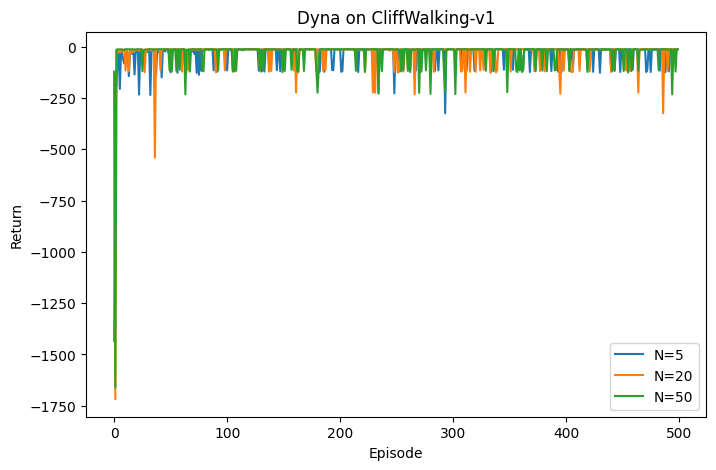

Sample efficiency (N=5): reached >-30 at episode 57
Sample efficiency (N=20): reached >-30 at episode 2
Sample efficiency (N=50): reached >-30 at episode 2

Policy for N=5
→ → → → → → → → → → → ↓
→ → → → → → → → → → ↓ ↓
→ → → → → → → → → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑

Policy for N=20
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑

Policy for N=50
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
→ → → → → → → → → → → ↓
↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑ ↑


In [69]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque


env = gym.make("CliffWalking-v1")
n_states = env.observation_space.n
n_actions = env.action_space.n

def epsilon_greedy(Q, state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(n_actions)
    return np.argmax(Q[state])

def run_dyna(planning_steps=N, n_episodes=n_episodes):
    Q = np.zeros((n_states, n_actions))
    model = {}
    returns = []

    for ep in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False

        while not done:
            action = epsilon_greedy(Q, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward


            target = reward if done else reward + gamma * np.max(Q[next_state])
            Q[state, action] += alpha * (target - Q[state, action])
            model[(state, action)] = (reward, next_state, done)


            keys = list(model.keys())
            for _ in range(planning_steps):
                s_p, a_p = keys[np.random.randint(len(keys))]
                r_p, s_p_next, done_p = model[(s_p, a_p)]
                target_p = r_p if done_p else r_p + gamma * np.max(Q[s_p_next])
                Q[s_p, a_p] += alpha * (target_p - Q[s_p, a_p])

            state = next_state

        returns.append(total_reward)

    return returns, Q

def sample_efficiency(returns,threshold=-30,window=100):
    moving = np.convolve(returns, np.ones(window)/window, mode="valid")
    for i, avg in enumerate(moving):
        if avg > threshold:
            return i

    return None

def visualize_policy(Q, title="Policy"):
    arrows = {0: "↑", 1: "→", 2: "↓", 3: "←"}
    grid = np.array([arrows[np.argmax(Q[s])] for s in range(n_states)])
    print(f"\n{title}")

    for r in range(4):
        print(" ".join(grid[r*12:(r+1)*12]))

planning_values = [5,20,50]
all_return_nums = {}
cumulative_Qs = {}

for N in planning_values:
    returns,Q = run_dyna(N)
    all_return_nums[N] = returns
    cumulative_Qs[N] = Q


plt.figure(figsize=(8,5))
for N, returns in all_return_nums.items():
    plt.plot(returns, label=f"N={N}")

plt.xlabel("Episode")
plt.ylabel("Return")
plt.title("Dyna on CliffWalking-v1")
plt.legend()
plt.show()


for N, returns in all_return_nums.items():
    ep_index = sample_efficiency(returns, threshold, window)
    print(f"Sample efficiency (N={N}): reached >{threshold} at episode {ep_index}")


for N, Q in cumulative_Qs.items():
    visualize_policy(Q, title=f"Policy for N={N}")


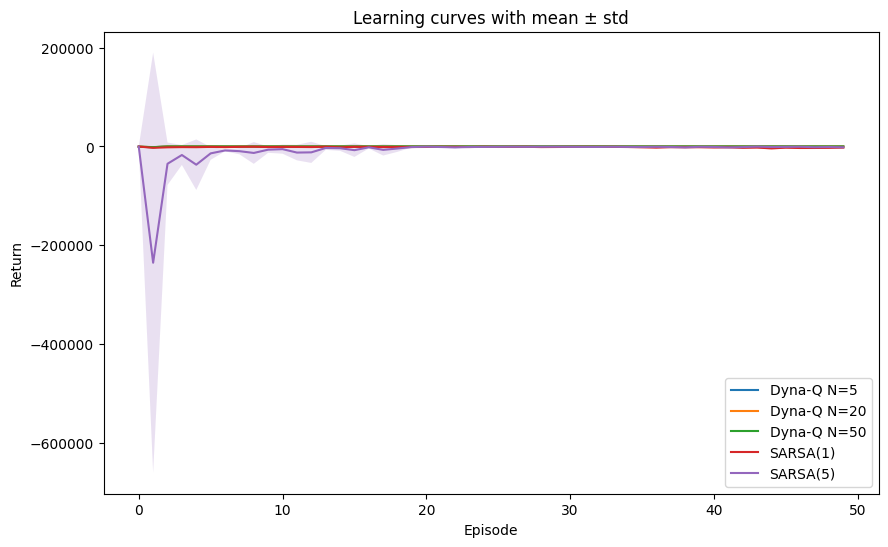


Sample efficiency (first episode where avg return > -30):
Dyna-Q N=5: [32, 17, 22, 44, 40]
Dyna-Q N=20: [11, 11, 11, 14, 11]
Dyna-Q N=50: [11, 17, 11, 11, 17]
SARSA(1): [None, None, None, None, None]
SARSA(5): [None, None, None, None, None]


In [70]:
def run_all(n_episodes=50, seeds=5, threshold=-30):

    planning_values = [5, 20, 50]
    results = {"Dyna": {N: [] for N in planning_values},
               "SARSA1": [],
               "SARSA5": []}

    for seed in range(seeds):
        np.random.seed(seed)


        for N in planning_values:
            r, _ = run_dyna(planning_steps=N, n_episodes=n_episodes)
            results["Dyna"][N].append(r)


        r1, _ = run_sarsa_n(n_episodes=n_episodes, n_step=1)
        results["SARSA1"].append(r1)


        r5, _ = run_sarsa_n(n_episodes=n_episodes, n_step=5)
        results["SARSA5"].append(r5)


    for N in planning_values:
        results["Dyna"][N] = np.vstack(results["Dyna"][N])

    results["SARSA1"] = np.vstack(results["SARSA1"])
    results["SARSA5"] = np.vstack(results["SARSA5"])

    plt.figure(figsize=(10,6))
    for N in planning_values:
        mean = results["Dyna"][N].mean(axis=0)
        std = results["Dyna"][N].std(axis=0)
        plt.plot(mean, label=f"Dyna-Q N={N}")
        plt.fill_between(range(n_episodes), mean-std, mean+std, alpha=0.2)

    for name, label in [("SARSA1", "SARSA(1)"), ("SARSA5", "SARSA(5)")]:
        mean = results[name].mean(axis=0)
        std = results[name].std(axis=0)
        plt.plot(mean, label=label)
        plt.fill_between(range(n_episodes), mean-std, mean+std, alpha=0.2)

    plt.xlabel("Episode")
    plt.ylabel("Return")
    plt.title("Learning curves with mean ± std")
    plt.legend()
    plt.show()

    print("\nSample efficiency (first episode where avg return > -30):")
    for N in planning_values:
        vals = [first_pass_threshold(r, threshold) for r in results["Dyna"][N]]
        print(f"Dyna-Q N={N}: {vals}")

    vals = [first_pass_threshold(r, threshold) for r in results["SARSA1"]]
    print(f"SARSA(1): {vals}")
    vals = [first_pass_threshold(r, threshold) for r in results["SARSA5"]]
    print(f"SARSA(5): {vals}")



run_all(n_episodes=50, seeds=5, threshold=-30)


Discussion:

Sample efficiency:

Dyna is the only one to exceed -30 in 50 episodes because it ultimately takes advantage of what it knows about the envorinment using its model, which the others do not have. Through the simulated steps in can learn more quicker. It also helps that the environment is so straight foward. Here are the results for Dyna:

Dyna N=5: [32, 17, 22, 44, 40]
Dyna N=20: [11, 11, 11, 14, 11]
Dyna N=50: [11, 17, 11, 11, 17]


Stability near the cliff: Dyna obviously hugs the cliff whereas the others do not given that they take more than 30 steps. We can also see from the visualization that dyna found the optimal path and policy.

Sensitivity to planning steps: We see a large jump as N goes from 5 to 20. So here it is very sensitive to planning. However after this, there is really very little difference for N = 50. This is likely because the optimal number of steps is far lower than this.

## Exercise 3: Solve FrozenLake with Q-Learning and Dyna-Q (Stochastic Model)

**Objective**  
Implement and compare **Q-learning** and **Dyna-Q** on Gymnasium’s `FrozenLake-v1`.  
For Dyna-Q, your learned **transition model must handle multiple possible next states** per `(s, a)` (stochastic slip), i.e., store and sample **a distribution** over `(s', r)` outcomes rather than a single next state.

---

### Environment
- Use `FrozenLake-v1` from `gymnasium.envs.toy_text`.
- You can start with map 4×4; and then work with 8×8.
- Start → Goal with slippery transitions (stochastic).  
- Rewards: `+1` at goal, `0` otherwise (holes terminate with 0).

---

### Part A — Q-learning (baseline)
1. Maintain a tabular action-value function `Q[s, a]`.
2. Behavior: ε-greedy over `Q`.
3. Update after each real step:
   - target = r + γ * max_a' Q[s', a']   (if terminal: target = r)
   - Q[s, a] ← Q[s, a] + α * (target − Q[s, a])
4. Train for several thousand episodes (e.g., 5,000) with an ε schedule (e.g., 0.2 → 0.01).

---

### Part B — Dyna-Q with a **stochastic transition model**
1. **Empirical model (multinomial):** for each `(s, a)`, maintain a multiset of observed outcomes:
   - `model[(s, a)] = [(s'_1, r_1, count_1), (s'_2, r_2, count_2), ...]`
   - Update counts whenever you observe `(s, a, r, s')`.
2. **Real step update (Q-learning):** same as Part A.
3. **Planning steps (N per real step):**
   - Sample a previously seen `(s_p, a_p)` uniformly (or with priority).
   - Sample `(s'_p, r_p)` **from the empirical distribution** for `(s_p, a_p)` using counts as probabilities.
   - Apply the same Q-learning backup with `(s_p, a_p, r_p, s'_p)`.
4. Train with the same ε schedule and number of episodes; vary `N ∈ {5, 20, 50}`.

---

### Experiments & Analysis
1. **Learning curves:** plot episode index vs episode return (smoothed) for:
   - Q-learning
   - Dyna-Q (N=5, 20, 50)
2. **Sample efficiency:** report the episode at which the moving-average return (e.g., window 100) first exceeds a threshold (you choose a reasonable value).
3. **Effect of stochastic modeling:** briefly explain why storing a distribution over `(s', r)` matters on FrozenLake (slip), and what happens if you store only the most recent outcome.
4. **Robustness:** run ≥5 random seeds; report mean ± std of final evaluation returns.

---

### Deliverables
- **Code** for Q-learning and Dyna-Q (with stochastic model).  
- **Plots** of learning curves (include legend and axis labels).  
- ** Discussion:** why Dyna-Q helps here; impact of N; importance of modeling multiple next states.

---

### Hints
- For terminal transitions (goal/hole), the Q-learning target is simply `target = r` (no bootstrap).  
- When sampling from the model, use probabilities `p_i = count_i / sum_j count_j`.  
- Tie-break greedy action selection uniformly among argmax actions to avoid bias.  
- Keep evaluation **greedy (ε=0)** and consistent across methods (same seeds and episode counts).
